In [1]:
import os

chkpt_root = '/mnt/tess/astronet/checkpoints/ext_36_run_1'
data_files = '/mnt/tess/astronet/tfrecords-36-val/*'
tces_file = '/mnt/tess/astronet/tces-v13-val.csv'

nruns = 10

def load_ensemble(chkpt_root, nruns):
    checkpts = []
    for i in range(nruns):
        parent = os.path.join(chkpt_root, str(i + 1))
        if not os.path.exists(parent):
            break
        all_dirs = os.listdir(parent)
        if not all_dirs:
            break
        d, = all_dirs
        checkpts.append(os.path.join(parent, d))
    return checkpts

paths = load_ensemble(chkpt_root, nruns)
paths

['/mnt/tess/astronet/checkpoints/ext_36_run_1/1/AstroCNNModel_extended_20220418_220440',
 '/mnt/tess/astronet/checkpoints/ext_36_run_1/2/AstroCNNModel_extended_20220418_223806',
 '/mnt/tess/astronet/checkpoints/ext_36_run_1/3/AstroCNNModel_extended_20220418_231105',
 '/mnt/tess/astronet/checkpoints/ext_36_run_1/4/AstroCNNModel_extended_20220418_234404',
 '/mnt/tess/astronet/checkpoints/ext_36_run_1/5/AstroCNNModel_extended_20220419_001704',
 '/mnt/tess/astronet/checkpoints/ext_36_run_1/6/AstroCNNModel_extended_20220419_005009',
 '/mnt/tess/astronet/checkpoints/ext_36_run_1/7/AstroCNNModel_extended_20220419_012323',
 '/mnt/tess/astronet/checkpoints/ext_36_run_1/8/AstroCNNModel_extended_20220419_015632',
 '/mnt/tess/astronet/checkpoints/ext_36_run_1/9/AstroCNNModel_extended_20220419_022933',
 '/mnt/tess/astronet/checkpoints/ext_36_run_1/10/AstroCNNModel_extended_20220419_030247']

In [2]:
import getpass
import os
from astronet import predict
import tensorflow as tf


def run_predictions(path):
    predict.FLAGS = predict.parser.parse_args([
      '--model_dir', path,
      '--data_files', data_files,
      '--output_file', '',
    ])

    return predict.predict()


paths = load_ensemble(chkpt_root, nruns)
ensemble_preds = []
config = None
for i, path in enumerate(paths):
    print(f'Running model {i + 1}')
    preds, config = run_predictions(path)
    ensemble_preds.append(preds.set_index('astro_id'))
    print()

Running model 1
2491 records
Running model 2
2491 records
Running model 3
2491 records
Running model 4
2491 records
Running model 5
2491 records
Running model 6
2491 records
Running model 7
2491 records
Running model 8
2491 records
Running model 9
2491 records
Running model 10
2491 records


In [3]:
labels = ['disp_e', 'disp_n', 'disp_j', 'disp_s', 'disp_b']

col_e = labels.index('disp_e')
thresh = 0.2

In [4]:
import numpy as np
import pandas as pd

agg_preds = {}

for preds in ensemble_preds:
    for ex_id in preds.index:
        if ex_id not in agg_preds:
            agg_preds[ex_id] = []

        row = preds[preds.index == ex_id]
        pred_v = row.values[0]
        if len(row.values) > 1:
            print(f'Warning: duplicate predictions for {ex_id}')
        if pred_v[col_e] >= thresh:
            agg_preds[ex_id].append('disp_e')
        else:
            masked_v = [v if i != col_e else 0 for i, v in enumerate(pred_v)]
            agg_preds[ex_id].append(preds.columns[np.argmax(masked_v)])

In [5]:
final_preds = []
for ex_id in list(agg_preds.keys()):
    counts = {l: 0 for l in labels}
    for e in agg_preds[ex_id]:
        counts[e] += 1
    maxcount = max(counts.values())
    counts.update({
        'astro_id': ex_id,
        'maxcount': maxcount,
    })
    final_preds.append(counts)
    
final_preds = pd.DataFrame(final_preds).set_index('astro_id')

In [6]:
tce_table = pd.read_csv(tces_file, header=0, low_memory=False)
tce_table['astro_id'] = tce_table['Astro ID']
tce_table = tce_table.set_index('astro_id')
for l in labels:
    tce_table[l] = tce_table[l[:-1] + l[-1].upper()]
tce_labels = tce_table[labels + ['TIC ID']]

pl = final_preds.join(tce_labels, on='astro_id', how='left', lsuffix='_p')

pl.head()
pd.set_option('display.max_columns', None)

In [7]:
ppos = (pl['disp_e_p'] > 0)
pos = (pl['disp_e'] > 0)

pneg = (pl['disp_e_p'] == 0)
neg = (pl['disp_e'] == 0)

print('Recall:', len(pl[ppos & pos]) / len(pl[pos]))
print('Precision:', len(pl[ppos & pos]) / len(pl[ppos]))

Recall: 0.9846743295019157
Precision: 0.7099447513812155


In [8]:
for i in pl[pos & pneg]['TIC ID']:
    print(i)

334227600
118412801
158159741
141753278


In [9]:
for i in pl[neg & ppos]['TIC ID']:
    print(i)

252588526
164528404
332870317
192591652
198555242
431338538
278910035
16740282
91987762
237278147
277848886
154214348
279064110
136651206
269291226
468608862
97487520
82242456
202685576
405687343
127846210
298647682
469465627
138847344
284266496
56861756
395164445
257048642
123489614
186483050
267924099
648359612
274510104
188258751
101496204
122577745
1254504863
200323039
241855882
30318046
335588842
406277413
74885707
842068824
356822358
387568679
18178958
165500081
261814771
408945155
283330382
219880693
356776209
371070027
278555119
27896467
375927073
409455240
14209654
21133246
417208086
308805406
154271808
1400086045
159636125
230197530
320356995
404934011
419611478
404851508
407615704
167039826
201601338
31868634
30275847
291374558
30722286
404851966
384341508
113496703
309650507
261205462
167309408
406971913
276738707
373919592
446698252
40602499
404851552
319865847
183978683
177309966
326693475
293527927
311103813
299945796
279475851
300153494
404733023
348957284
379191982
281

In [10]:
def compare(ensemble_preds, filter):
    result = ensemble_preds[0][filter]
    for preds in ensemble_preds[1:]:
        result = result.append(preds[filter])
    return result

compare(ensemble_preds, preds.index == pl[pl['TIC ID'] == 1254504863].index.values[0])

,disp_e,disp_n,disp_j,disp_s,disp_b
astro_id,,,,,
26515,0.022890,0.287101,0.954274,0.013066,0.098700
26515,0.089768,0.268334,0.850962,0.013706,0.071733
26515,0.014189,0.254812,0.976890,0.006133,0.064631
26515,0.275941,0.280015,0.669470,0.007276,0.052003
26515,0.293262,0.233573,0.600856,0.004744,0.079062
26515,0.303522,0.226982,0.631944,0.007804,0.053399
26515,0.034375,0.292017,0.936042,0.007071,0.086588
26515,0.005786,0.203824,0.983114,0.006492,0.109582
26515,0.028705,0.305460,0.951059,0.008402,0.065230


In [11]:
pl[pl.index == pl[pl['TIC ID'] == 1254504863].index.values[0]]

,disp_e_p,disp_n_p,disp_j_p,disp_s_p,disp_b_p,maxcount,disp_e,disp_n,disp_j,disp_s,disp_b,TIC ID
astro_id,,,,,,,,,,,,
26515,3,0,7,0,0,7,0,0,5,0,2,1254504863


### PR curve

In [33]:
ids = set(ensemble_preds[0].index.values)

index = {v: i for i, v in enumerate(ids)}

pred_es = np.zeros([len(ensemble_preds), len(index)])
for i, preds in enumerate(ensemble_preds):
    for row in preds.iterrows():
        ex_id, pred_e = row[0], row[1][col_e]
        pred_es[i][index[ex_id]] = pred_e

lbl_es = np.zeros([len(index)], dtype=np.bool)
for row in tce_labels.iterrows():
    ex_id, lbl_e = row[0], row[1]['disp_e']
    lbl_es[index[ex_id]] = (lbl_e > 0)

In [34]:
num_cond_pos = int(np.sum(lbl_es))

def pr_at_th(th):
    pred_pos = np.any(pred_es >= th, axis=0)
    true_pos = pred_pos & lbl_es
    num_pred_pos = int(np.sum(pred_pos))
    num_true_pos = int(np.sum(true_pos))
    if num_pred_pos == 0:
        return 1.0, 0.0
    return float(num_true_pos) / float(num_pred_pos), float(num_true_pos) / float(num_cond_pos)

AUC: 0.975307112022389, max R: 1.0, max P: 1.0
100% recall at: 42%, threshold: 0.015999403953606828


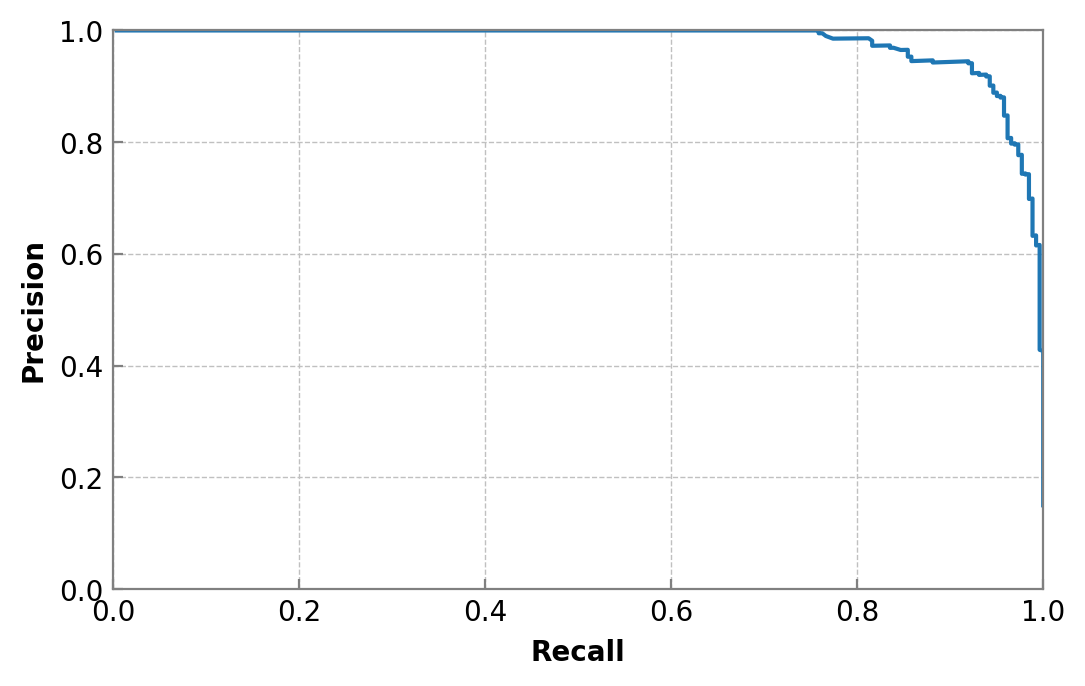

In [35]:
from matplotlib import pyplot as plt

ps, rs, ths = ([], [], [])
th = np.max(pred_es)
while th >= 0.0:
    p, r = pr_at_th(th)
    ps.append(p)
    rs.append(r)
    ths.append(th)
    th -= 0.0005
    
from sklearn import metrics

print(f'AUC: {metrics.auc(rs, ps)}, max R: {max(rs)}, max P: {max(ps)}')
    
i = len(rs) - 1
while rs[i] == 1.0:
    i -= 1
i += 1
print(f'100% recall at: {int(ps[i] * 100)}%, threshold: {ths[i]}')

fig, ax = plt.subplots(figsize=(6, 3.7), dpi=200)

ax.spines['top'].set_color('#808080')
ax.spines['right'].set_color('#808080')
ax.spines['left'].set_color('#808080')
ax.spines['bottom'].set_color('#808080')
ax.tick_params(direction='in', color='#808080')

plt.grid(color='#c0c0c0', linestyle='--', linewidth=0.5)

plt.ylabel('Precision', fontweight='bold')
plt.xlabel('Recall', fontweight='bold')

plt.xlim((0.0, 1.0))
plt.ylim((0.0, 1.0))

_ = plt.plot(rs, ps)